# Análisis Final, Cuellos de Botella V.3

Se procede a realizar el análisis final del proyecto, en donde se incorporarán las demás zonas operacionales que quedan pendientes.
Las tareas pendientes son: 

1. Analizar el tiempo promedio, min y máx para los tiempos de espera antes de entrar a la cancha. (Listo en V1)
2. Calcular el tiempo de espera perdido utilizando el tiempo calculado anteriormente. (Listo en V1)
3. Analizar las zonas restantes teniendo en cuenta el canchas y meses.
4. Analisis de monetización por tramo-Producto
5. Análisis de monetización romanas
6. Análisis del horario con mayor pérdida

__pd el dataset de colas tiene el filtro de las colas inferiores a 3 hrs__
# 5. Promedios y Peaks de Actividad y Cola (juntos) con los datos sin parcelar.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import datetime
import seaborn as sns
from manager_propio import *
from IPython.display import clear_output


In [2]:
cols = ['Total Time','Datei','Datef','Ti','Tf']

#Cargamos el dataset de actividades
actividad = pd.read_csv('actividad_v2.csv')
actividad = actividad.drop('Unnamed: 0',axis=1)
#actividad = actividad.drop(cols,axis=1)
actividad['Start Act'] = pd.to_datetime(actividad['Start Act'], utc = True).dt.tz_convert('Chile/Continental')
actividad['End Act'] = pd.to_datetime(actividad['End Act'], utc = True).dt.tz_convert('Chile/Continental')
actividad['date start'] = pd.to_datetime(actividad['Start Act']).dt.date
actividad['date end'] = pd.to_datetime(actividad['End Act']).dt.date
actividad['time start'] = pd.to_datetime(actividad['Start Act']).dt.time
actividad['time end'] = pd.to_datetime(actividad['End Act']).dt.time
actividad['Day of year [In]'] = pd.to_datetime(actividad['Start Act']).dt.dayofyear
actividad['Day of year [Out]'] = pd.to_datetime(actividad['End Act']).dt.dayofyear
actividad['time Act'] = ((actividad['End Act']) - pd.to_datetime(actividad['Start Act']))/np.timedelta64(1, 's')

#cargamos el dataset de las colas antiguas
colas_old = pd.read_csv('colas.csv')
colas_old = colas_old.drop('Unnamed: 0',axis=1)
colas_old['Start Cola'] = pd.to_datetime(colas_old['Start Cola'], utc = True).dt.tz_convert('Chile/Continental')
colas_old['End Cola'] = pd.to_datetime(colas_old['End Cola'], utc = True).dt.tz_convert('Chile/Continental')
colas_old['date start'] = pd.to_datetime(colas_old['Start Cola']).dt.date
colas_old['date end'] = pd.to_datetime(colas_old['End Cola']).dt.date
colas_old['time start'] = pd.to_datetime(colas_old['Start Cola']).dt.time
colas_old['time end'] = pd.to_datetime(colas_old['End Cola']).dt.time
colas_old['Day of year [In]'] = pd.to_datetime(colas_old['Start Cola']).dt.dayofyear
colas_old['Day of year [Out]'] = pd.to_datetime(colas_old['End Cola']).dt.dayofyear
colas_old['time cola'] = ((colas_old['End Cola']) - pd.to_datetime(colas_old['Start Cola']))/np.timedelta64(1, 's')

#Filtramos por el termino de las 3 hrs
colas_old = colas_old[(colas_old['time cola'] < 10800) & (colas_old['time cola'] > 0)]  #timepos mayores a 0 minutos y menores a 3 hrs


#Cargamos el dataset de las nuevas colas. con el filtro de las 3 horas
colas = pd.read_csv("colas_filtradas_v2.csv")  #ya tiene las horas cambiadas
colas = colas.drop('Unnamed: 0',axis=1)
colas['Start Cola'] = pd.to_datetime(colas['Start Cola'])
colas['End Cola'] = pd.to_datetime(colas['End Cola'])

In [3]:
#snit
colas = colas.replace(['SNIT | SNIT | SNIT | SNIT | SNIT | SNIT',
       'SNIT | SNIT | SNIT | SNIT',
       'SNIT | SNIT | SNIT | SNIT | SNIT | SNIT | SNIT','SNIT | SNIT | SNIT | SNIT | SNIT','SNIT | SNIT'], 'SNIT')
colas_old = colas_old.replace(['SNIT | SNIT | SNIT | SNIT | SNIT | SNIT',
       'SNIT | SNIT | SNIT | SNIT',
       'SNIT | SNIT | SNIT | SNIT | SNIT | SNIT | SNIT','SNIT | SNIT | SNIT | SNIT | SNIT','SNIT | SNIT'], 'SNIT')
#moph-silvinita
colas = colas.replace(['MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA | MOP-H-BL | MOP-H-BL | SILVINITA | MOP-H-BL | MOP-H-BL | MOP-H-BL',
       'SILVINITA | SILVINITA | MOP-H-BL | MOP-H-BL | SILVINITA | SILVINITA | SILVINITA | MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA',
       'MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA | MOP-H-BL | MOP-H-BL | SILVINITA | SILVINITA | MOP-H-BL | MOP-H-BL','MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA'],
        'MOP-H-BL | SILVINITA')
colas_old = colas_old.replace(['MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA | MOP-H-BL | MOP-H-BL | SILVINITA | MOP-H-BL | MOP-H-BL | MOP-H-BL',
       'SILVINITA | SILVINITA | MOP-H-BL | MOP-H-BL | SILVINITA | SILVINITA | SILVINITA | MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA',
       'MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA | MOP-H-BL | MOP-H-BL | SILVINITA | SILVINITA | MOP-H-BL | MOP-H-BL','MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA'],
        'MOP-H-BL | SILVINITA')

#moph
colas = colas.replace(['MOP-H-BL | MOP-H-BL','MOP-H-BL | MOP-H-BL | MOP-H-BL'],'MOP-H-BL')
colas_old = colas_old.replace(['MOP-H-BL | MOP-H-BL','MOP-H-BL | MOP-H-BL | MOP-H-BL'],'MOP-H-BL')

#duplicados
colas = colas.replace(['SSI | SSI','NPC-R SOLAR | NPC-R SOLAR','NPP-AJ50 | NPP-AJ50','SSR | SSR','QROP-K PLUS | QROP-K PLUS'],['SSI','NPC-R SOLAR','NPP-AJ50','SSR','QROP-K PLUS'])
colas_old = colas_old.replace(['SSI | SSI','NPC-R SOLAR | NPC-R SOLAR','NPP-AJ50 | NPP-AJ50','SSR | SSR','QROP-K PLUS | QROP-K PLUS'],['SSI','NPC-R SOLAR','NPP-AJ50','SSR','QROP-K PLUS'])

colas = colas.replace(['NPC-TA 50 F | NPC-TA 50 F', 'NPC-TA 50 H | NPC-TA 50 H', 'SSR-C | SSR-C', 'NPC-TA 50-I | NPC-TA 50-I'],
                     ['NPC-TA 50 F','NPC-TA 50 H','SSR-C','NPC-TA 50-I'])
colas_old = colas_old.replace(['NPC-TA 50 F | NPC-TA 50 F', 'NPC-TA 50 H | NPC-TA 50 H', 'SSR-C | SSR-C', 'NPC-TA 50-I | NPC-TA 50-I'],
                     ['NPC-TA 50 F','NPC-TA 50 H','SSR-C','NPC-TA 50-I'])
#########################################333
#actividad
#snit
actividad = actividad.replace(['SNIT | SNIT | SNIT | SNIT | SNIT | SNIT',
       'SNIT | SNIT | SNIT | SNIT',
       'SNIT | SNIT | SNIT | SNIT | SNIT | SNIT | SNIT','SNIT | SNIT | SNIT | SNIT | SNIT','SNIT | SNIT'], 'SNIT')
#moph-silvinita
actividad = actividad.replace(['MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA | MOP-H-BL | MOP-H-BL | SILVINITA | MOP-H-BL | MOP-H-BL | MOP-H-BL',
       'SILVINITA | SILVINITA | MOP-H-BL | MOP-H-BL | SILVINITA | SILVINITA | SILVINITA | MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA',
       'MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA | MOP-H-BL | MOP-H-BL | SILVINITA | SILVINITA | MOP-H-BL | MOP-H-BL','MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA',
        'SILVINITA | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA | MOP-H-BL | SILVINITA | SILVINITA | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | SILVINITA | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL', ],
        'MOP-H-BL | SILVINITA')


#moph
actividad = actividad.replace(['MOP-H-BL | MOP-H-BL','MOP-H-BL | MOP-H-BL | MOP-H-BL','MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL | MOP-H-BL'],'MOP-H-BL')
#duplicados
actividad = actividad.replace(['SSI | SSI','NPC-R SOLAR | NPC-R SOLAR','NPP-AJ50 | NPP-AJ50','SSR | SSR','QROP-K PLUS | QROP-K PLUS','SILVINITA | SILVINITA'],['SSI','NPC-R SOLAR','NPP-AJ50','SSR','QROP-K PLUS','SILVINITA'])

actividad = actividad.replace(['NPC-TA 50 F | NPC-TA 50 F', 'NPC-TA 50 H | NPC-TA 50 H', 'SSR-C | SSR-C', 'NPC-TA 50-I | NPC-TA 50-I'],
                     ['NPC-TA 50 F','NPC-TA 50 H','SSR-C','NPC-TA 50-I'])
actividad = actividad.replace(['NPC-TA 50 H | SPO | SSI | SSI | SSI | SSI | SSI | SSI | SSI | SSI | SSI | SSI | SSI | SSI | SSI | SSI | SSI | SSI | SSI | SSI | SSI | SSI | NK 15-0-2 | NK 15-0-2'],
                             'NPC-TA 50 H | SPO | SSI | NK 15-0-2')

In [4]:
def found_time_romanas(trayecto=None):
    if trayecto == None: 
        df_aux = actividad[~((actividad['Origin'] == 'Coya Sur') & (actividad['Destination'] == 'Coya Sur'))]
    else:
        aux = actividad[~((actividad['Origin'] == 'Coya Sur') & (actividad['Destination'] == 'Coya Sur'))]
        df_aux = aux[((aux['Origin'] == trayecto) | (aux['Origin'] == 'Coya Sur')) & 
                      ((aux['Destination'] == trayecto) | (aux['Destination'] == 'Coya Sur'))]
    romanas = ['Romana Salitre','Romana Mto','Romana 3']
    romanas_values = []
    for romana in romanas:
        aux_2 = df_aux[df_aux['ZO'] == romana]
        #A la 1era ZO.
        #print("Trayectos",aux_2.Origin.unique())
        a = aux_2[(aux_2['Pre Time'] <= 1500) & (aux_2['time start'] <= datetime.time(3,0,0))].describe()
        #a = aux_2.describe()
        tiempo_real = round(a.iloc[5,0]/60,1) + (round(a.iloc[5,3]/60,1))+6
        #print("pre time: ",round(a.iloc[5,0]/60,1))
        #print("act: ",(round(a.iloc[5,3]/60,1)))
        print("El tiempo a utilizar para esta romana, " + romana +" será: ", tiempo_real, " minutos")
        romanas_values.append([romana,tiempo_real])
    return romanas_values

def monetizacion(df,df_,zona,dia,fin=None,tiempo_ideal=35,zonas=None):
    """Entrega las horas perdidas, camiones perdidos y dinero max y min perdido para un
    determinado tiempo y zona operacional"""
        
    if fin == None:
        fin = dia+1
    else:
        fin +=1
    for i in range(dia,fin): 
        prom_cola = analisis_por_dia_2(df,i,i,1,25,None,condicion='end',metric='mean',zonas=zonas)
        a = stack_by_day(df_,zona,i,i,metric='mean')
        a['minutos'] = a['minutos/camion']*a['camiones']

        #calculo de dif_time
        dif_time = pd.concat([a[['block','minutos']],prom_cola[zona]],axis=1)
        dif_time["diferencia"] = dif_time['minutos']- dif_time[zona]*tiempo_ideal
        dif_time.loc[dif_time['diferencia'] < 0, 'diferencia'] = 0   

        #MONETIZACIÓN
        horas = (dif_time['diferencia'].sum())/60.
        camiones = horas/hr_job
        precio_minimo = (camiones * toneladas * price_min)/1000000.
        precio_maximo = (camiones * toneladas * price_max)/1000000.

        if i == dia:
            atributos = [horas,camiones,precio_minimo,precio_maximo]
        else:
            atributos = [horas+atributos[0],camiones+atributos[1],precio_minimo+atributos[2],precio_maximo+atributos[3]]
    return atributos
def analisis_por_dia_2(df,dia_inicial,dia_final,hora_incial=1,hora_final=25,name=None,condicion='end',metric='max',zonas=None):
    "Nos entrega el análisis por una cantidad X de dias, toma los días del año"
    count = 0
    df_final = None
    for i in range(dia_inicial,dia_final+1):
        #print(i)
        aux = dict_to_df_2(vehiculos_cola(df,i,i,1,25,condicion),zonas)
        if count == 0:
            df_final = aux
            count += 1
        else:
            if (metric == 'max'):
                df_final = pd.concat([df_final, aux]).max(level=0)   #Aquí indico que necesito los peaks
            elif (metric == 'mean'):
                df_final = pd.concat([df_final,aux]).mean(level=0)
    if name != None:
        df_final.sort_index(axis=0).to_csv(name,index=False)
    return df_final.sort_index(axis=0)

def dict_to_df_2(dictionary,zonas=None):
    """ Pasamos de Dicionario a df de la forma que nosotros necesitamos"""
    if zonas == None:
        zonas = ['Romana Salitre', 'C Secado L-4', 'C PTS', 'C NPT3', 'Romana Mto', 'C ATM', 'C NPT 1-2', 'C Prilado', 'Losa Envasado', 'C CS-4',
                 'C Secado L-3', 'C Granulacion', 'Galpones', 'C NPT4', 'C CS-12', 'C CS-P.Valdivia', 'Romana 3', 'C CS-11']
    test = np.arange(1,25,1)
    count=0
    #print(dictionary.items(), len(dictionary.items()))
    if len(dictionary.items()) == 0 :
        dictionary = {'C NPT3':{0:0}}
    for k, v in dictionary.items():
        
        a = pd.DataFrame.from_dict(v,'index')
        a = a.rename(columns={a.columns[0]:k})
        for i in test:
            if i not in a.index:
                #print("no esta este indice", i)
                a.loc[i] = 0.
        a = a.sort_index(axis=0)
        if (count == 0):
            b = a
            count +=1
            continue 
        else:
            b=pd.concat([b,a],axis=1)
    b = b.fillna(0.)
    cols_b = b.keys().tolist()
    diff = list(set(zonas) - set(cols_b))
    if (len(diff) > 0):
        for i in diff:
            b[i] = 0.
    
    b = b.reindex(sorted(b.columns), axis=1)
    return b


In [5]:
df_final_2019 = pd.read_csv('perdidas_mensuales_por_tramo_producto_2019_sin_romanas.csv')
df_final_2020 = pd.read_csv('perdidas_mensuales_por_tramo_producto_2020_sin_romanas.csv')

trayectos_totales = ['Salar de Atacama','Nueva Victoria','Tocopilla','Puerto Angamos']
productos = df_final_2019.producto.unique().tolist()
for i in trayectos_totales:
    print("------------")
    #print("Trayecto ",i, "\n",df_final_2019[df_final_2019['trayecto'] == i].iloc[:,10:].sum() + df_final_2020[df_final_2020['trayecto'] == i].iloc[:,10:].sum())
    for j in productos:
        print("Trayecto, ",i, " el producto ",j, "\n",df_final_2019[(df_final_2019['trayecto'] == i) & (df_final_2019['producto']==j)].iloc[:,10:].sum() + 
              df_final_2020[(df_final_2020['trayecto'] == i) & (df_final_2020['producto']==j)].iloc[:,10:].sum())
    clear_output(wait=True)

------------
Trayecto,  Puerto Angamos  el producto  MOP-H-BL 
 Precio Promedio [Millones CLP]    0.0
dtype: float64
Trayecto,  Puerto Angamos  el producto  SILVINITA 
 Precio Promedio [Millones CLP]    0.0
dtype: float64
Trayecto,  Puerto Angamos  el producto  SNIT 
 Precio Promedio [Millones CLP]    0.0
dtype: float64
Trayecto,  Puerto Angamos  el producto  NPC-TA 50 F 
 Precio Promedio [Millones CLP]    0.0
dtype: float64
Trayecto,  Puerto Angamos  el producto  NPC-TA 50 H 
 Precio Promedio [Millones CLP]    0.0
dtype: float64
Trayecto,  Puerto Angamos  el producto  SSI 
 Precio Promedio [Millones CLP]    0.0
dtype: float64
Trayecto,  Puerto Angamos  el producto  QROP-KS 
 Precio Promedio [Millones CLP]    0.0
dtype: float64
Trayecto,  Puerto Angamos  el producto  QROP-K PLUS 
 Precio Promedio [Millones CLP]    0.0
dtype: float64


In [6]:
pesos_romanas = found_time_romanas()

El tiempo a utilizar para esta romana, Romana Salitre será:  20.1  minutos
El tiempo a utilizar para esta romana, Romana Mto será:  17.1  minutos
El tiempo a utilizar para esta romana, Romana 3 será:  16.6  minutos


In [7]:
#Quitamos febrero
dias_mes = [[1,31],[32,60],[61,91],[92,121],[122,152],[153,160],[182,212],[213,243],[244,273],[274,304],[305,334],[335,365]]
meses = ['Enero','Febrero','Marzo','Abril','Mayo','Junio','Julio','Agosto','Septiembre','Octubre','Noviembre','Diciembre']
meses_2020 = ['Enero','Febrero','Marzo','Abril','Mayo','Junio']
meses_2019 = ['Julio','Agosto','Septiembre','Octubre','Noviembre','Diciembre']
meses_del_año = dict(zip(meses, dias_mes)) 
trayectos_totales = ['Salar de Atacama','Nueva Victoria','Tocopilla','Puerto Angamos']
#Parametros
toneladas = 29.5
price_min = 9500 
price_max = 13000
hr_job = 16
final_result = []

# for trayecto in trayectos_totales:
#     for romana in pesos_romanas:
#         #filtramos colas old
#         aux = colas_old[~((colas_old['Origin'] == 'Coya Sur') & (colas_old['Destination'] == 'Coya Sur'))]
#         df = aux[((aux['Origin'] == trayecto) | (aux['Origin'] == 'Coya Sur')) & ((aux['Destination'] == trayecto) | (aux['Destination'] == 'Coya Sur'))]
#         df = df[df['ZO']==romana[0]]
#         #filtramos colas
#         aux_ = colas[~((colas['Origin'] == 'Coya Sur') & (colas['Destination'] == 'Coya Sur'))]
#         df_ = aux_[((aux_['Origin'] == trayecto) | (aux_['Origin'] == 'Coya Sur')) & ((aux_['Destination'] == trayecto) | (aux_['Destination'] == 'Coya Sur'))]
#         df_ = df_[df_['ZO']==romana[0]]
#         for mes in meses:
#             aux_2 = df[(df['Day of year [In]'] >= meses_del_año[mes][0]) & (df['Day of year [In]'] <= meses_del_año[mes][1])]
#             print(mes, trayecto, romana)
#             aux_3 = monetizacion(df,df_,romana[0],meses_del_año[mes][0],meses_del_año[mes][1],romana[1])
#             aux_4 = [trayecto,romana[0],mes]
#             result = aux_4 + aux_3
#             final_result.append(result)
#             clear_output(wait=True)
                
# df_final = pd.DataFrame(final_result,columns=['trayecto','zona','Mes','Horas','N° Camiones','Precio Min [Millones CLP]','Precio Max [Millones CLP]'])
# df_final["Precio Promedio [Millones CLP]"] = (df_final["Precio Max [Millones CLP]"] + df_final["Precio Min [Millones CLP]"])/2.
#df_final.to_csv("perdidas_mensuales_por_tramo_romanas_v1.csv")
df_final = pd.read_csv("perdidas_mensuales_por_tramo_romanas_v1.csv")

In [8]:
df_final

Unnamed: 0          trayecto            zona         Mes     Horas  \
0             0  Salar de Atacama  Romana Salitre       Enero  3.225000   
1             1  Salar de Atacama  Romana Salitre     Febrero  2.246667   
2             2  Salar de Atacama  Romana Salitre       Marzo  5.846667   
3             3  Salar de Atacama  Romana Salitre       Abril  2.348333   
4             4  Salar de Atacama  Romana Salitre        Mayo  0.681667   
..          ...               ...             ...         ...       ...   
139         139    Puerto Angamos        Romana 3      Agosto  0.000000   
140         140    Puerto Angamos        Romana 3  Septiembre  0.000000   
141         141    Puerto Angamos        Romana 3     Octubre  0.000000   
142         142    Puerto Angamos        Romana 3   Noviembre  0.000000   
143         143    Puerto Angamos        Romana 3   Diciembre  0.000000   

     N° Camiones  Precio Min [Millones CLP]  Precio Max [Millones CLP]  \
0       0.201563                   0.056488                   0.077299   
1       0.140417                   0.039352                   0.053850   
2       0.365417                   0.102408                   0.140137   
3       0.146771                   0.041133                   0.056287   
4       0.042604                   0.011940                   0.016339   
..           ...                        ...                        ...   
139     0.000000                   0.000000                   0.000000   
140     0.000000                   0.000000                   0.000000   
141     0.000000                   0.000000                   0.000000   
142     0.000000                   0.000000                   0.000000   
143     0.000000                   0.000000                   0.000000   

     Precio Promedio [Millones CLP]  
0                          0.066894  
1                          0.046601  
2                          0.121273  
3                          0.048710  
4                          0.014139  
..                              ...  
139                        0.000000  
140                        0.000000  
141                        0.000000  
142                        0.000000  
143                        0.000000  

[144 rows x 9 columns]

In [33]:
df_final[(df_final['Mes']=='Enero') | (df_final['Mes']=='Febrero') | (df_final['Mes']=='Marzo') | (df_final['Mes']=='Abril') | (df_final['Mes']=='Mayo')].sum()[8]

31.70699179687501

In [32]:
for i in pesos_romanas:
    print(i[0]," dinero perdido: ", round(df_final[df_final['zona']==i[0]].sum()[8],1), " Millones")

Romana Salitre  dinero perdido:  21.3  Millones
Romana Mto  dinero perdido:  2.2  Millones
Romana 3  dinero perdido:  19.2  Millones


In [10]:
df_final.describe()

Unnamed: 0       Horas  N° Camiones  Precio Min [Millones CLP]  \
count  144.000000  144.000000   144.000000                 144.000000   
mean    71.500000   14.317882     0.894868                   0.250787   
std     41.713307   30.491688     1.905731                   0.534081   
min      0.000000    0.000000     0.000000                   0.000000   
25%     35.750000    0.000000     0.000000                   0.000000   
50%     71.500000    2.111667     0.131979                   0.036987   
75%    107.250000   14.994167     0.937135                   0.262632   
max    143.000000  189.418333    11.838646                   3.317780   

       Precio Max [Millones CLP]  Precio Promedio [Millones CLP]  
count                 144.000000                      144.000000  
mean                    0.343182                        0.296984  
std                     0.730848                        0.632464  
min                     0.000000                        0.000000  
25%                     0.000000                        0.000000  
50%                     0.050614                        0.043801  
75%                     0.359391                        0.311012  
max                     4.540121                        3.928951

In [34]:
df_final.sum()

Unnamed: 0                                                                    10296
trayecto                          Salar de AtacamaSalar de AtacamaSalar de Ataca...
zona                              Romana SalitreRomana SalitreRomana SalitreRoma...
Mes                               EneroFebreroMarzoAbrilMayoJunioJulioAgostoSept...
Horas                                                                       2061.78
N° Camiones                                                                 128.861
Precio Min [Millones CLP]                                                   36.1133
Precio Max [Millones CLP]                                                   49.4182
Precio Promedio [Millones CLP]                                              42.7657
dtype: object

## Análisis de horario con mayor pérdida.

In [12]:
def stack_by_day(df,zone,dia_inicial,dia_final,metric='max',name=None,origen=None):
    "Nos entrega el análisis por una cantidad X de dias, toma los días del año"
    count = 0
    df_final = None
    if (origen != None):
        df = df[df['Origin'] == origen]
    for i in range(dia_inicial,dia_final+1):
        #print(i)
        aux,_ = convert_df_to_df(df,zone,i)
        if count == 0:
            df_final = aux
            count += 1
        else:
            if (metric == 'max'):
                df_final = pd.concat([df_final, aux]).max(level=0)   #Aquí indico que necesito los peaks
            elif (metric == 'mean'):
                df_final = pd.concat([df_final,aux]).mean(level=0)
    if name != None:
        df_final.sort_index(axis=0).to_csv(name,index=False)
    return df_final.sort_index(axis=0)

def monetizacion_horaria(df,df_,dia,fin=None,tiempo_ideal=30,zonas=None):
    """Entrega las horas perdidas, camiones perdidos y dinero max y min perdido para un
    determinado tiempo y zona operacional"""
    zonas = ['C Secado L-4', 'C PTS', 'C NPT3', 'C ATM', 'C NPT 1-2', 'C Prilado', 'Losa Envasado', 'C CS-4',
                 'C Secado L-3', 'C Granulacion', 'Galpones', 'C NPT4', 'C CS-12', 'C CS-P.Valdivia', 'C CS-11']    
    if fin == None:
        fin = dia+1
    else:
        fin +=1
    count = 0
    contador = 0
    for i in range(dia,fin): 
        prom_cola = analisis_por_dia_2(df,i,i,1,25,None,condicion='end',metric='mean',zonas=zonas)
        for j in zonas:
            a = stack_by_day(df_,j,i,i,metric='mean')
            a['minutos'] = a['minutos/camion']*a['camiones']
            print(i)
            #calculo de dif_time
            dif_time = pd.concat([a[['block','minutos']],prom_cola[j]],axis=1)
            #print(dif_time)
            dif_time = dif_time.rename(columns={j: "camiones/bloque"})
            #print(dif_time)
            dif_time["diferencia min"] = dif_time['minutos']- dif_time["camiones/bloque"]*tiempo_ideal
            dif_time.loc[dif_time['diferencia min'] < 0, 'diferencia min'] = 0   
            #concatenamos los dias
            if count == 0:
                df_aux = dif_time
                count +=1
            else:
                df_aux = df_aux + dif_time
            contador += 1
            clear_output(wait=True)

    #MONETIZACIÓN
    df_aux['block'] = df_aux['block']/contador
    horas = (df_aux['diferencia min'].sum())/60.
    camiones = horas/hr_job
    precio_minimo = (camiones * toneladas * price_min)/1000000.
    precio_maximo = (camiones * toneladas * price_max)/1000000.
    atributos = [horas,camiones,precio_minimo,precio_maximo]
    precio_promedio = (price_max+price_min)/2
    df_aux['horas'] = df_aux['diferencia min']/60.
    df_aux['camiones'] = df_aux['horas']/hr_job
    df_aux['Monetizacion [Millones]'] = (df_aux['camiones']*toneladas * precio_promedio)/1000000
    df_horarios = df_aux[['block','horas','camiones','Monetizacion [Millones]']]
    return df_horarios



In [16]:
# df_horario_2020 = monetizacion_horaria(colas_old,colas,1,160)
# df_horario_2019 = monetizacion_horaria(colas_old,colas,181,365)
# df_horario_2020.to_csv('perdidas_por_horario_2020.csv')
# df_horario_2019.to_csv('perdidas_por_horario_2019.csv')
df_horario_2020 = pd.read_csv('perdidas_por_horario_2020.csv')
df_horario_2019 = pd.read_csv('perdidas_por_horario_2019.csv')
# df_horario_anual = df_horario_2019+df_horario_2020
# df_horario_anual['block'] = df_horario_anual['block']/2
# df_horario_anual.to_csv('perdidas_por_horario_2019-2020.csv')

df_horario_anual = pd.read_csv('perdidas_por_horario_2019-2020.csv')

df_horario_anual

Unnamed: 0  block        horas    camiones  Monetizacion [Millones]
0            1    1.0    28.983333    1.811458                 0.601178
1            2    2.0    82.600000    5.162500                 1.713305
2            3    3.0   192.633333   12.039583                 3.995637
3            4    4.0   576.466667   36.029167                11.957180
4            5    5.0  1344.316667   84.019792                27.884068
5            6    6.0  1641.716667  102.607292                34.052795
6            7    7.0  1335.416667   83.463542                27.699463
7            8    8.0  1157.833333   72.364583                24.015996
8            9    9.0  1184.750000   74.046875                24.574307
9           10   10.0  1697.083333  106.067708                35.201221
10          11   11.0  2141.183333  133.823958                44.412826
11          12   12.0  1855.000000  115.937500                38.476758
12          13   13.0  1660.516667  103.782292                34.442748
13          14   14.0  1430.583333   89.411458                29.673428
14          15   15.0  1209.516667   75.594792                25.088021
15          16   16.0  1485.700000   92.856250                30.816668
16          17   17.0  2611.833333  163.239583                54.175137
17          18   18.0  2465.466667  154.091667                51.139172
18          19   19.0  1254.850000   78.428125                26.028334
19          20   20.0   618.850000   38.678125                12.836303
20          21   21.0   367.516667   22.969792                 7.623100
21          22   22.0   444.500000   27.781250                 9.219902
22          23   23.0   315.616667   19.726042                 6.546580
23          24   24.0     6.733333    0.420833                 0.139664

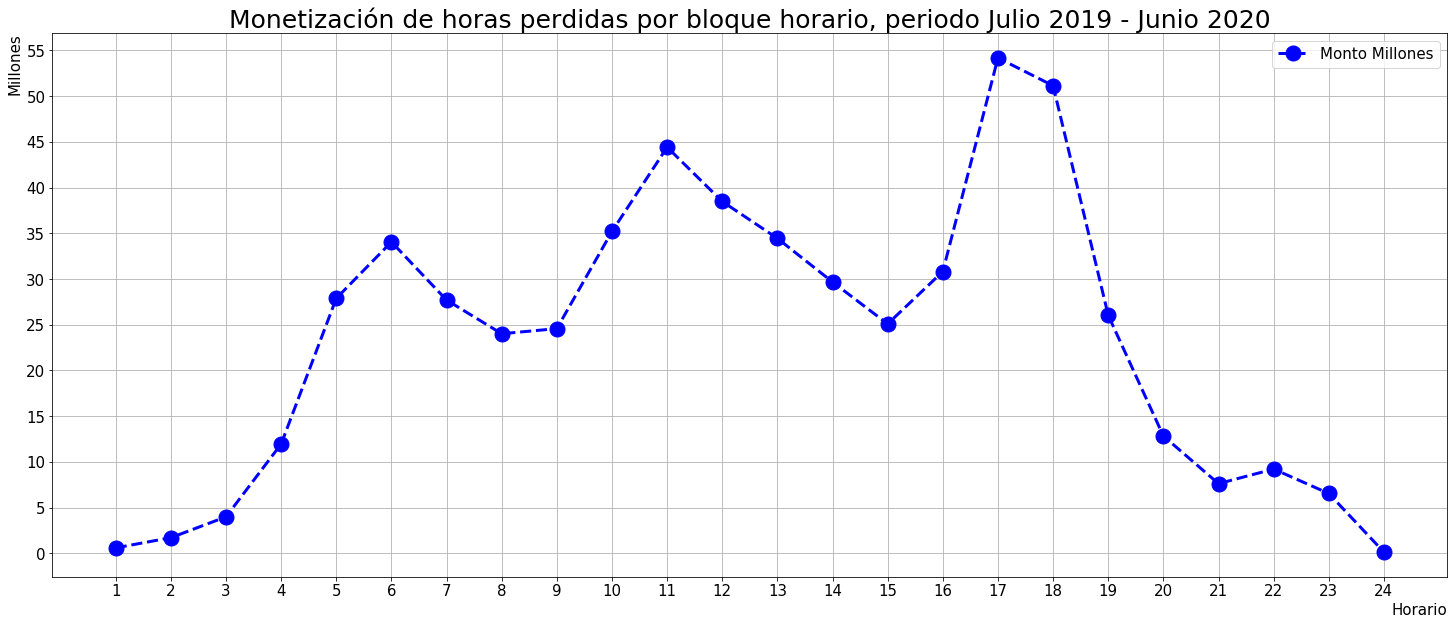

In [30]:
plt.figure(figsize=(25,10))
plt.plot(df_horario_anual['block'],df_horario_anual['Monetizacion [Millones]'],'bo--',markersize=15,lw=3,label='Monto Millones')
plt.legend(fontsize=15)
plt.xlabel("Horario",position=(1,1),ha='right',fontsize=15)
plt.ylabel("Millones",position=(1,1),ha='right',fontsize=15)
plt.title("Monetización de horas perdidas por bloque horario, periodo Julio 2019 - Junio 2020",fontsize=25)
plt.xticks(np.arange(1,25,1),fontsize=15)
plt.yticks(np.arange(0,60,5),fontsize=15)
plt.grid(True)
plt.savefig('monetizacion_por_bloque.png')
plt.show()


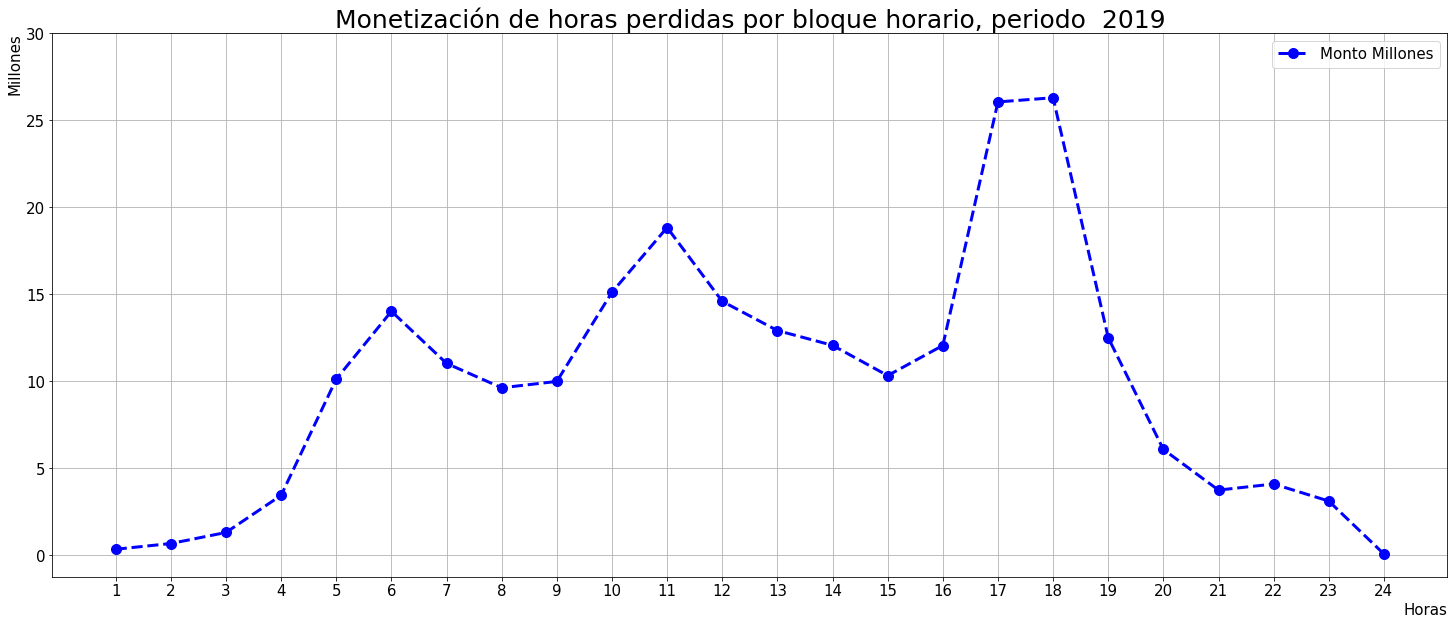

In [29]:
plt.figure(figsize=(25,10))
plt.plot(df_horario_2019['block'],df_horario_2019['Monetizacion [Millones]'],'bo--',markersize=10,lw=3,label='Monto Millones')
plt.legend(fontsize=15)
#plt.xlabel("Horario",fontsize=15)
#plt.ylabel("Millones",fontsize=15)
plt.xlabel('Horas', position=(1,1),ha='right',fontsize=15)
plt.ylabel('Millones',position=(1,1),ha='right',fontsize=15)
plt.title("Monetización de horas perdidas por bloque horario, periodo  2019",fontsize=25)
plt.xticks(np.arange(1,25,1),fontsize=15)
plt.yticks(np.arange(0,35,5),fontsize=15)
plt.grid(True)
plt.savefig('monetizacion_por_bloque_2019.png')
plt.show()

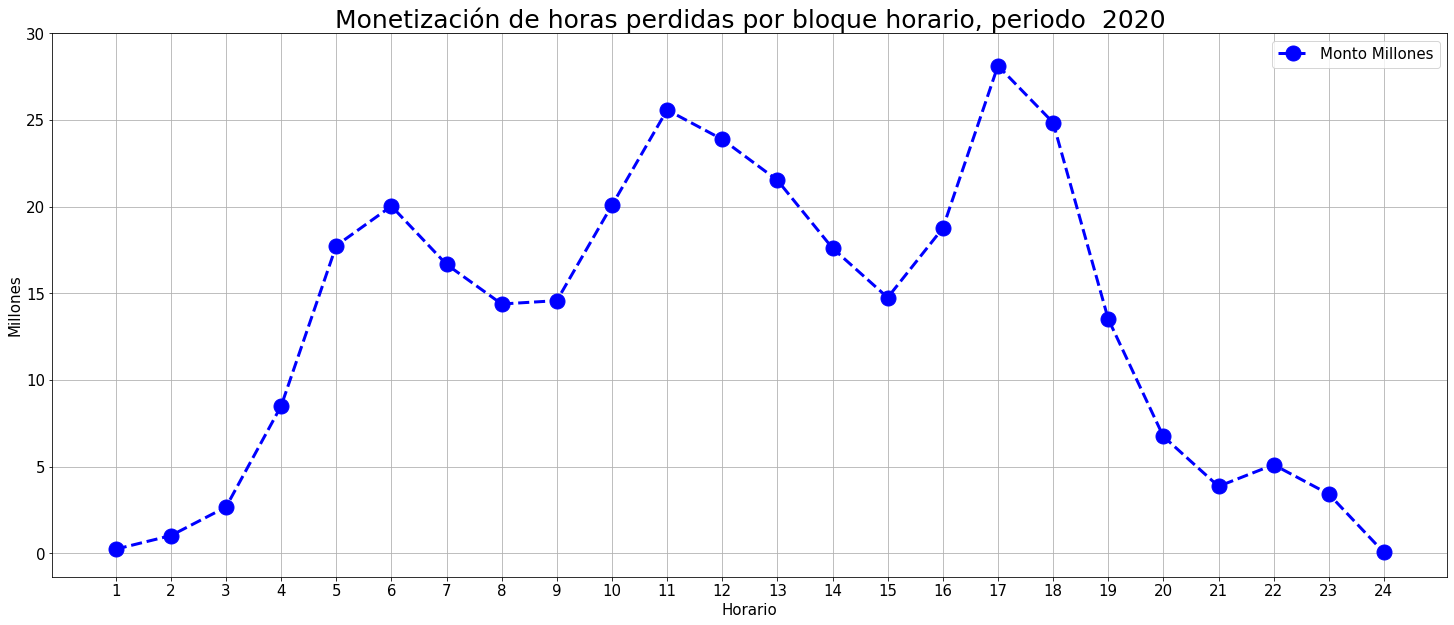

In [19]:
plt.figure(figsize=(25,10))
plt.plot(df_horario_2020['block'],df_horario_2020['Monetizacion [Millones]'],'bo--',markersize=15,lw=3,label='Monto Millones')
plt.legend(fontsize=15)
plt.xlabel("Horario",fontsize=15)
plt.ylabel("Millones",fontsize=15)
plt.title("Monetización de horas perdidas por bloque horario, periodo  2020",fontsize=25)
plt.xticks(np.arange(1,25,1),fontsize=15)
plt.yticks(np.arange(0,35,5),fontsize=15)
plt.grid(True)
plt.savefig('monetizacion_por_bloque_2020.png')
plt.show()

In [20]:
perdidas =  pd.read_csv('perdidas_mensuales_por_tramo_producto_sin_romanas_v1.csv')
perdidas.sum()

Unnamed: 0                                                                   252658
trayecto                          Salar de AtacamaSalar de AtacamaSalar de Ataca...
producto                          MOP-H-BLMOP-H-BLMOP-H-BLMOP-H-BLMOP-H-BLMOP-H-...
Mes                               EneroEneroEneroEneroEneroEneroEneroEneroEneroF...
Zona                              C NPT3C PriladoC ATMC NPT4C CS-12C Secado L-4C...
Horas                                                                       18165.2
N° Camiones                                                                 1135.33
Precio Min [Millones CLP]                                                   318.175
Precio Max [Millones CLP]                                                   435.398
Precio Promedio [Millones CLP]                                              376.787
dtype: object

In [21]:
zonas = ['C Secado L-4', 'C PTS', 'C NPT3', 'C ATM', 'C NPT 1-2', 'C Prilado', 'Losa Envasado', 'C CS-4',
        'C Secado L-3', 'C Granulacion', 'Galpones', 'C NPT4', 'C CS-12', 'C CS-P.Valdivia', 'C CS-11'] 
romanas = ['Romana Salitre','Romana Mto', 'Romana 3']
monetizacion_zonas = []
for i in zonas:
    mean = perdidas[perdidas['Zona']==i].sum()[9]
    maximo = perdidas[perdidas['Zona']==i].sum()[8]
    minimo = perdidas[perdidas['Zona']==i].sum()[7]
    monetizacion_zonas.append([i,mean,minimo,maximo])
for j in romanas:
    mean = df_final[df_final['zona']==j].sum()[7]
    maximo = df_final[df_final['zona']==j].sum()[6]
    minimo = df_final[df_final['zona']==j].sum()[5]
    monetizacion_zonas.append([j,mean,minimo,maximo])
monetizacion_zonas

[['C Secado L-4', 27.987986718749998, 23.634299895833333, 32.341673541666665],
 ['C PTS', 11.436066796875002, 9.657123072916669, 13.215010520833333],
 ['C NPT3', 230.13090585937502, 194.33276494791676, 265.9290467708333],
 ['C ATM', 5.505322265625001, 4.648938802083335, 6.361705729166667],
 ['C NPT 1-2', 9.051752343749996, 7.643701979166668, 10.459802708333333],
 ['C Prilado', 5.1717878906250005, 4.367287552083334, 5.976288229166667],
 ['Losa Envasado', 10.842356250000002, 9.1557675, 12.528945000000002],
 ['C CS-4', 70.835192578125, 59.816384843749994, 81.85400031249999],
 ['C Secado L-3', 0.7430542968750001, 0.6274680729166668, 0.8586405208333334],
 ['C Granulacion', 0.6664810546875, 0.5628062239583332, 0.7701558854166667],
 ['Galpones', 1.3651470703125, 1.1527908593749998, 1.5775032812499998],
 ['C NPT4', 2.48588203125, 2.099189270833333, 2.8725747916666675],
 ['C CS-12', 0.256027734375, 0.21620119791666667, 0.2958542708333334],
 ['C CS-P.Valdivia',
  0.21599531249999998,
  0.1823960

In [22]:
zonas_monetizacion = pd.DataFrame(monetizacion_zonas, columns=['Zona','promedio [Millones]','minimo [Millones]','maximo [Millones]'])
zonas_monetizacion.to_csv('perdidas_por_zona.csv')
zonas_monetizacion

Zona  promedio [Millones]  minimo [Millones]  maximo [Millones]
0      C Secado L-4            27.987987          23.634300          32.341674
1             C PTS            11.436067           9.657123          13.215011
2            C NPT3           230.130906         194.332765         265.929047
3             C ATM             5.505322           4.648939           6.361706
4         C NPT 1-2             9.051752           7.643702          10.459803
5         C Prilado             5.171788           4.367288           5.976288
6     Losa Envasado            10.842356           9.155767          12.528945
7            C CS-4            70.835193          59.816385          81.854000
8      C Secado L-3             0.743054           0.627468           0.858641
9     C Granulacion             0.666481           0.562806           0.770156
10         Galpones             1.365147           1.152791           1.577503
11           C NPT4             2.485882           2.099189           2.872575
12          C CS-12             0.256028           0.216201           0.295854
13  C CS-P.Valdivia             0.215995           0.182396           0.249595
14          C CS-11             0.092718           0.078295           0.107140
15   Romana Salitre            24.600007          64.146042          17.976928
16       Romana Mto             2.576121           6.717396           1.882550
17         Romana 3            22.242041          57.997500          16.253799

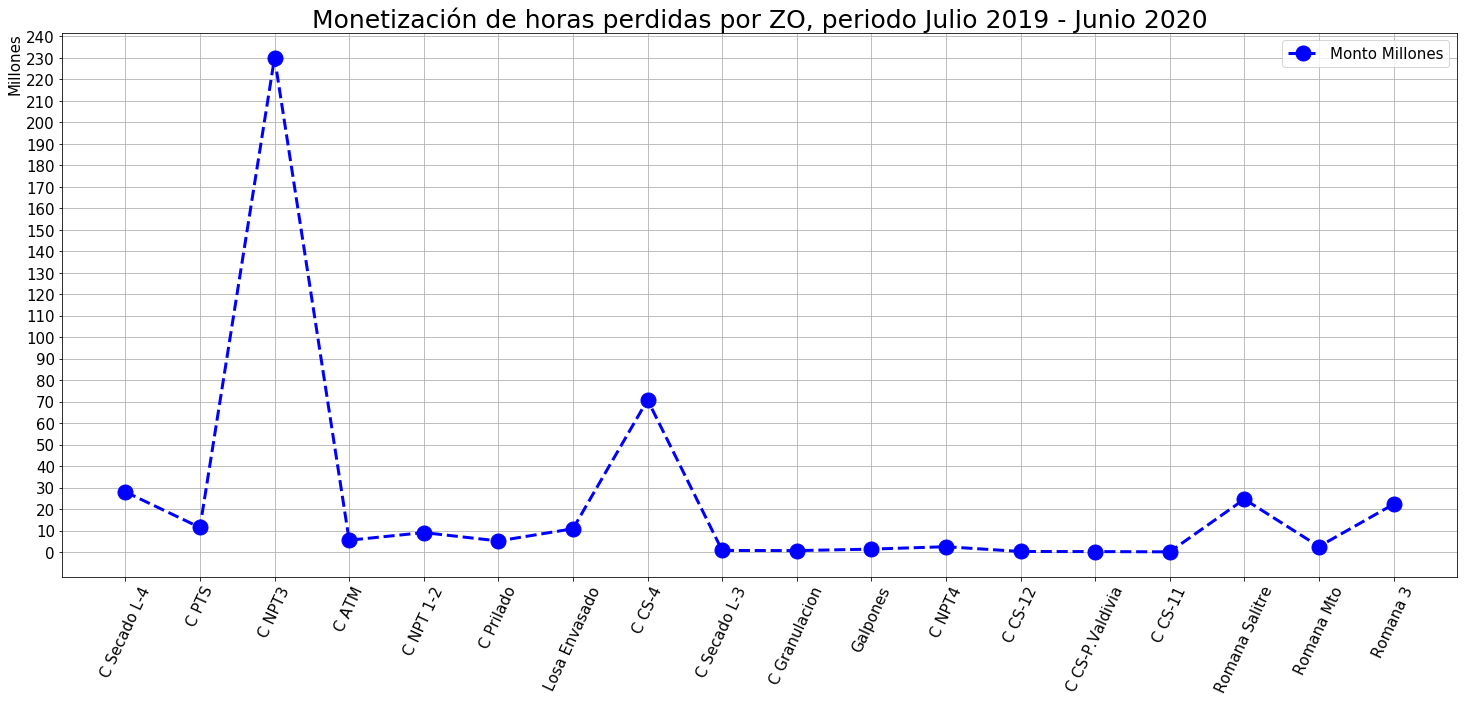

In [31]:
plt.figure(figsize=(25,10))
plt.plot(zonas_monetizacion['Zona'],zonas_monetizacion['promedio [Millones]'],'bo--',markersize=15,lw=3,label='Monto Millones')
plt.legend(fontsize=15)
#plt.xlabel("Zonas",fontsize=15)
plt.ylabel("Millones",position=(1,1),ha='right',fontsize=15)
plt.title("Monetización de horas perdidas por ZO, periodo Julio 2019 - Junio 2020",fontsize=25)
plt.xticks(fontsize=15,rotation=65)
plt.yticks(np.arange(0,250,10),fontsize=15)
plt.grid(True)
plt.savefig('monetizacion_por_zona_2019-2020.png')
plt.show()

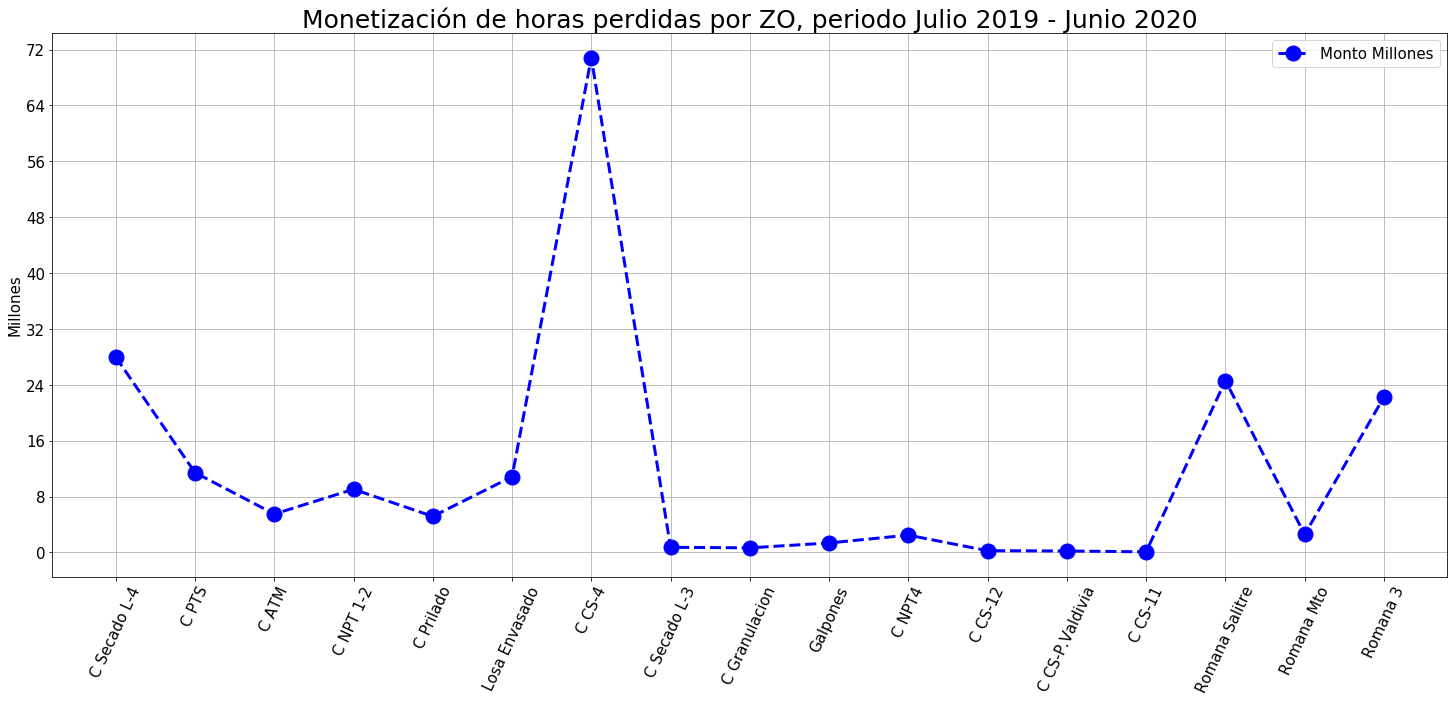

In [24]:
a = zonas_monetizacion[(zonas_monetizacion['Zona'] != 'C NPT3')]

plt.figure(figsize=(25,10))
plt.plot(a['Zona'],a['promedio [Millones]'],'bo--',markersize=15,lw=3,label='Monto Millones')
plt.legend(fontsize=15)
#plt.xlabel("Zonas",fontsize=15)
plt.ylabel("Millones",fontsize=15)
plt.title("Monetización de horas perdidas por ZO, periodo Julio 2019 - Junio 2020",fontsize=25)
plt.xticks(fontsize=15,rotation=65)
plt.yticks(np.arange(0,80,8),fontsize=15)
plt.grid(True)
plt.savefig('monetizacion_por_zona_2019-2020_sin_NPT3.png')
plt.show()

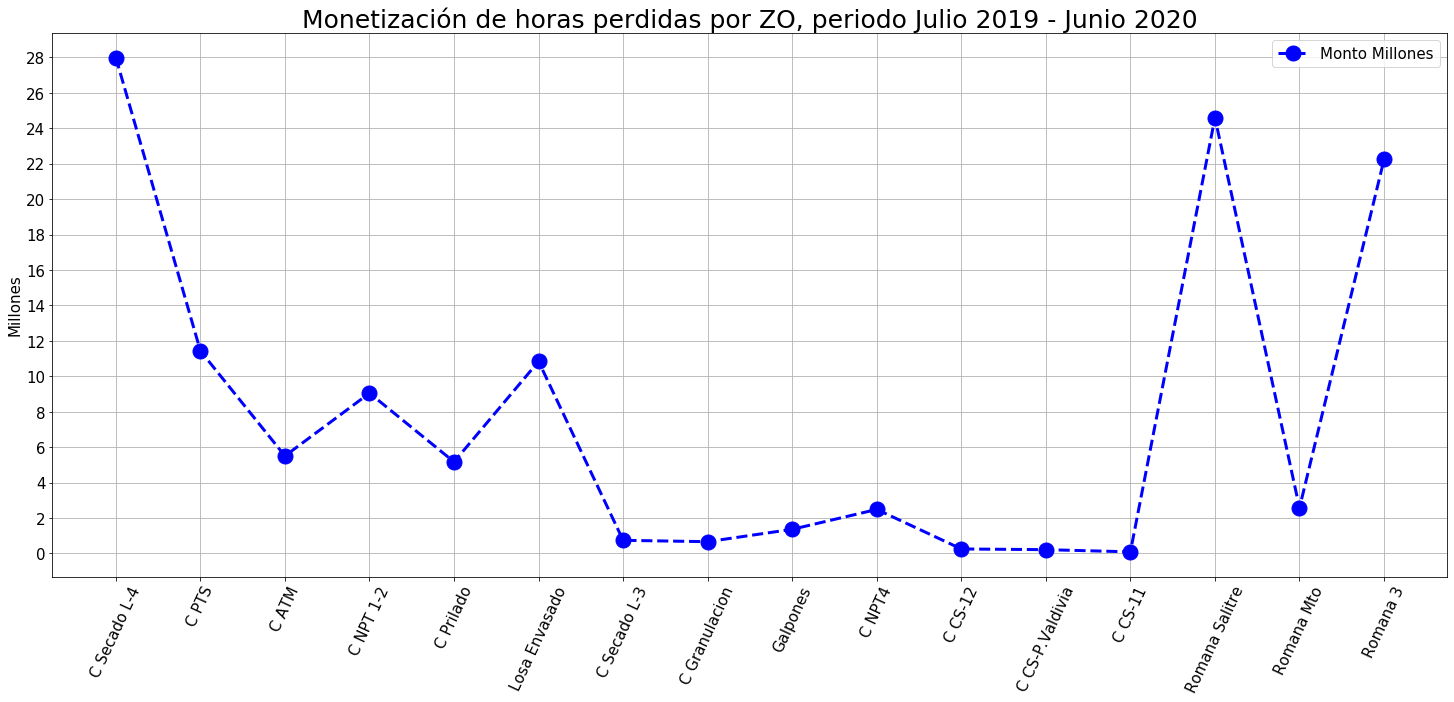

In [25]:
a = zonas_monetizacion[(zonas_monetizacion['Zona'] != 'C NPT3') & (zonas_monetizacion['Zona'] != 'C CS-4')]

plt.figure(figsize=(25,10))
plt.plot(a['Zona'],a['promedio [Millones]'],'bo--',markersize=15,lw=3,label='Monto Millones')
plt.legend(fontsize=15)
#plt.xlabel("Zonas",fontsize=15)
plt.ylabel("Millones",fontsize=15)
plt.title("Monetización de horas perdidas por ZO, periodo Julio 2019 - Junio 2020",fontsize=25)
plt.xticks(fontsize=15,rotation=65)
plt.yticks(np.arange(0,30,2),fontsize=15)
plt.grid(True)
plt.savefig('monetizacion_por_zona_2019-2020_sin_NPT3-CS4.png')
plt.show()